In [121]:

import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [158]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
df = train.append(test).reset_index()

In [88]:
import sys
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe.head()

for col in binary_cols:
    df = label_encoder(df, col)

In [170]:
### NEW FEATURES
df["Floorcross_tersr"] = (df["2ndFlrSF"] + df["1srFlrSF"]) / df["1stFlrSF"]
df["Total_Floor"] = df["1stFlrSF"] + df["2ndFlrSF"]
df["_Floor_cross"] =(df["1stFlrSF"] * (df["1stFlrSF"] + df["2ndFlrSF"]) 
df["Zemin_Alan_Kullanımı"] = ((df["GrLivArea"] / df["1stFlrSF"]) +1)
df["Alana_düşen_Mutfak"] =  df["KitchenAbvGr"] / df["1stFlrSF"]
df["bodrum_banyo_per"]  =  (df["BsmtFullBath"]) /  df["TotalBsmtSF"] 
df['mean_1stFlrSF_GrLivArea'] = df[['1stFlrSF', 'GrLivArea']].mean(axis=1)
df['std_1stFlrSF_GrLivArea'] = df[['1stFlrSF', 'GrLivArea']].std(axis=1)
df['BsmtQual'].fillna('No_Basement', inplace=True)
df['BsmtCond'].fillna('No_Basement', inplace=True)
df['BsmtExposure'].fillna('No_Basement', inplace=True)
df['BsmtFinType1'].fillna('No_Basement', inplace=True)
df['BsmtFinType2'].fillna('No_Basement', inplace=True)
df['FireplaceQu'].fillna('No_Fireplace', inplace=True)
df['GarageType'].fillna('No_Garage', inplace=True)
df['GarageFinish'].fillna('No_Garage', inplace=True)
df['GarageQual'].fillna('No_Garage', inplace=True)
df['GarageCond'].fillna('No_Garage', inplace=True)
df['PoolQC'].fillna('No_Garage', inplace=True)
df["sold_build"] = (df["YrSold"]/df["YearBuilt"])
df["Lot_divide"] = (df["LotArea"] / df["LotFrontage"])

SyntaxError: invalid syntax (4018670042.py, line 5)

In [134]:
df["GrLivArea"].head()

0    1710
1    1262
2    1786
3    1717
4    2198
Name: GrLivArea, dtype: int64

In [154]:
### NEW VARIABLES

df["Functional"] = np.where(df.Functional.isin(["Sev", "Maj2", "Maj1","Mod"]), "smmm", df["Functional"])
df["BldgType"] = np.where(df.BldgType.isin(["2fmCon", "Twnhs"]), "2T", df["BldgType"])
df["HouseStyle"] = np.where(df.HouseStyle.isin(["2.5Fin", "1.5Unf" ,"2.5Unf","SFoyer"]), "121", df["HouseStyle"])
df["ExterQual"] = np.where(df.ExterQual.isin(["Fa", "Ex"]), "FaEx", df["ExterQual"])
df["Foundation"] = np.where(df.Foundation.isin(["Wood", "Stone","Slab","BrkTil"]), "2T", df["Foundation"])
df["MSZoning"] = np.where(df.MSZoning.isin(["C (all)", "RH"]), "CRH", df["MSZoning"])
df["Fireplaces"] = np.where(df.Fireplaces.isin(["4", "3"]), "43", df["Fireplaces"])
df["GarageCars"] = np.where(df.GarageCars.isin(["4.000", "5.000"]), "45", df["GarageCars"])
df["Condition1"] = np.where(df.Condition1.isin(["RRNn", "RRNe","RRAn"]), "RRR", df["Condition1"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["AsbShng", "AsphShn"]), "AA", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["Brk Cmn", "BrkFace"]), "BB", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["Other", "Stone","CBlock"]), "OSC", df["Exterior2nd"])

In [155]:
####  DROPPING COLUMNS
df.drop("PoolArea", axis=1, inplace=True)
drop_list = ["index", "MiscFeature","Fence","PoolQC","GarageCond","Alley"]
df.drop(drop_list, axis=1, inplace=True)

In [ ]:
########## Fuctional

#aggregations_FC = { "GarageCars" : ["min", "max"],
   #                     "GarageArea" : ["mean"],
    #                 "EnclosedPorch": ["mean"],
     #                "1stFlrSF" : ["mean", "min", "std", "max"],
      #               "KitchenAbvGr": ["min", "max"],
       #             "BedroomAbvGr": ["mean", "std", "var"],
        #             "TotRmsAbvGrd": ["mean"]
         #              }
#Functional = df.groupby('Functional').agg(aggregations_FC)
 
#Functional.columns = pd.Index(['Functional' + e[0] + "_" + e[1].upper() for e in Functional.columns.tolist()])

#df.drop(["GarageCars","GarageArea","EnclosedPorch","1stFlrSF","KitchenAbvGr", "BedroomAbvGr","TotRmsAbvGrd"],axis=1, inplace=True)


#df = df.join(Functional, how='left', on="Functional")   



######## MSZoning

aggregations_MS = {"LotFrontage":["sum","mean"],
                    "LotArea": ["min", "mean","sum","max"],
                    "Street":["nunique", "size"],
                     "LandContour": ["nunique"],
                    "LandSlope": ["nunique"],
                      }
MSZoning = df.groupby('MSZoning').agg(aggregations_MS)

MSZoning.columns = pd.Index(['MSZoning' + e[0] + "_" + e[1].upper() for e in MSZoning.columns.tolist()])
 
df.drop(["LotFrontage","MiscVal", "LotArea", "Street", "LandContour", "LandSlope" ],axis=1, inplace=True)
    
df = df.join(MSZoning, how='left', on='MSZoning')   




####### MSSubClass



aggregations_BC = { "WoodDeckSF": ["mean","sum","max"],
                    "OpenPorchSF":["min", "mean","sum","max"],
                    "TotalBsmtSF": ["mean","sum","max"],
                     "GrLivArea": ["min", "max", "size"],
                      "Build" : ["min","max"],
                       "2ndFlrSF" : ["var", "std", "mean","min"]
                       }
MSSubClass = df.groupby('MSSubClass').agg(aggregations_BC)

MSSubClass.columns = pd.Index(['MSSubClass' + e[0] + "_" + e[1].upper() for e in MSSubClass.columns.tolist()])
    
df.drop(["2ndFlrSF","Build", "WoodDeckSF", "OpenPorchSF", "GrLivArea",  "TotalBsmtSF" ],axis=1, inplace=True)

df = df.join(MSSubClass, how='left', on='MSSubClass')   




df.drop("Std_Build", axis=1, inplace=True)

In [156]:
def grab_col_names(dataframe, cat_th=20, car_th=100, num_th = 118):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in "SalePrice" and col not in "Id"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols, num_but_cat


cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 84
cat_cols: 52
num_cols: 30
cat_but_car: 0
num_but_cat: 12


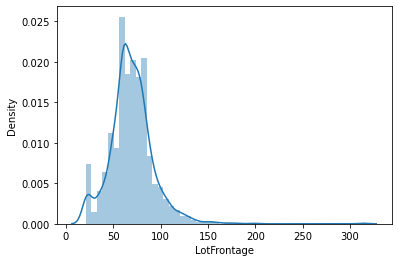

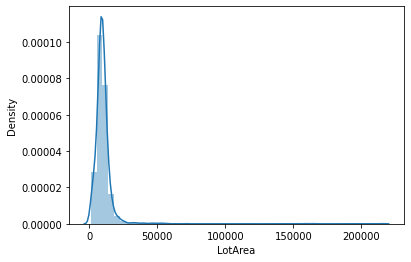

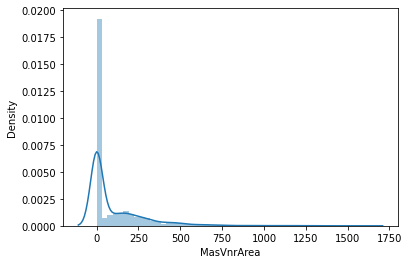

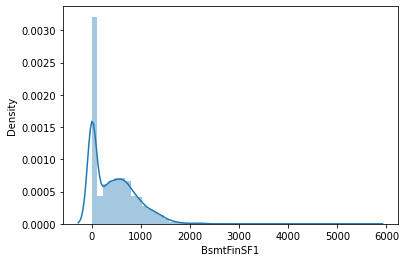

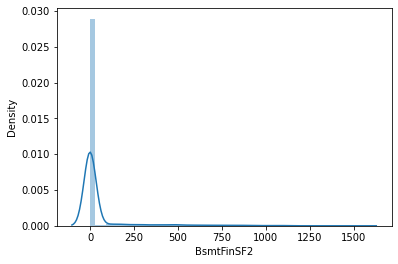

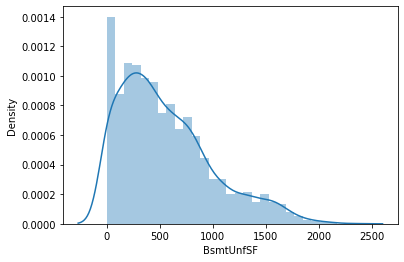

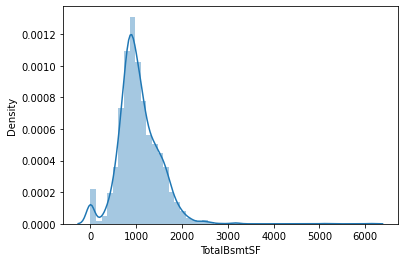

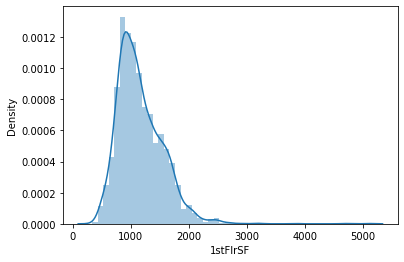

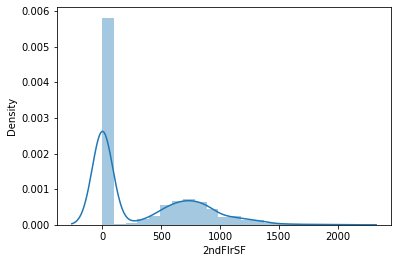

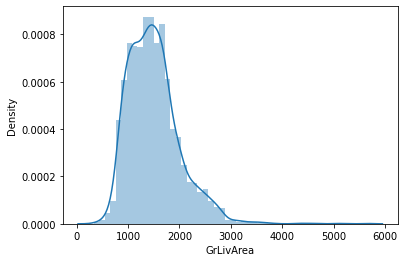

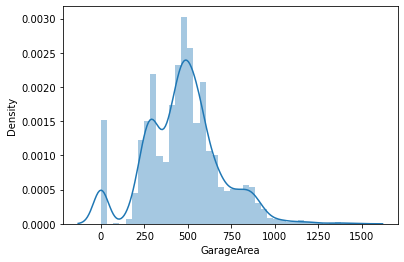

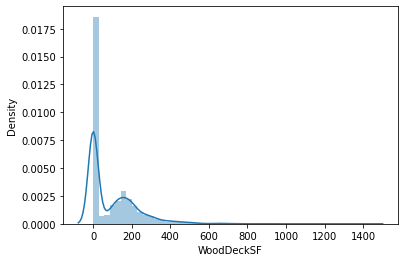

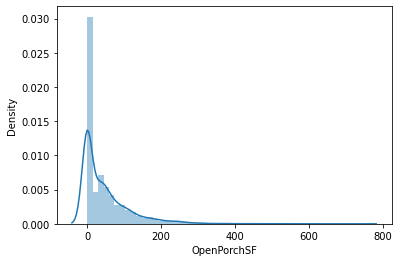

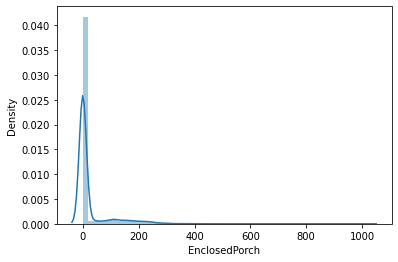

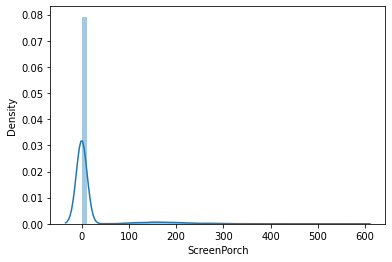

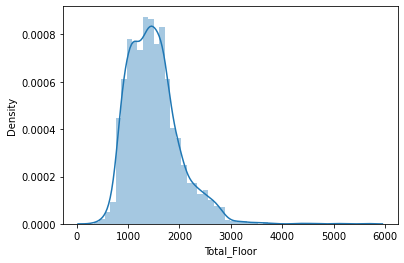

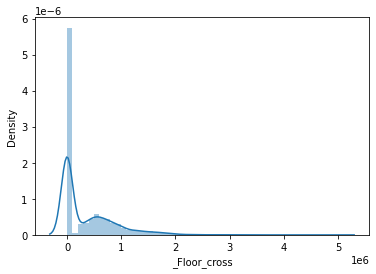

In [16]:
for col in num_cols:
    sns.distplot(df[col]) 
    plt.show()

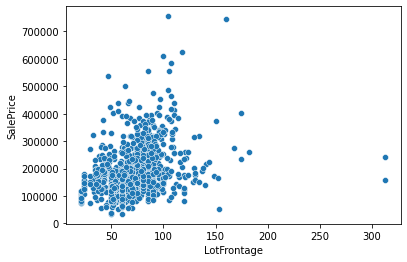

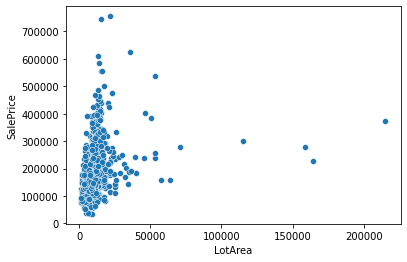

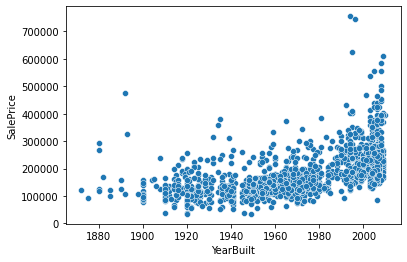

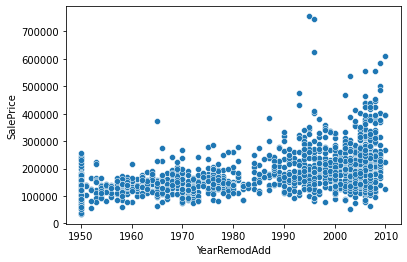

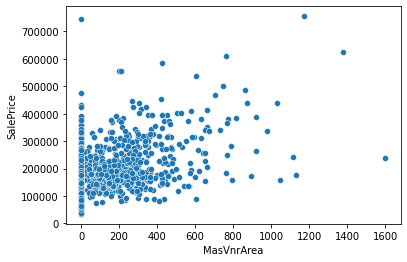

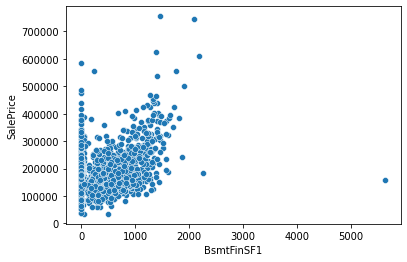

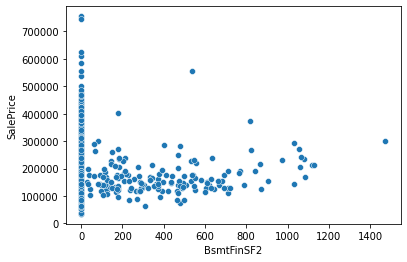

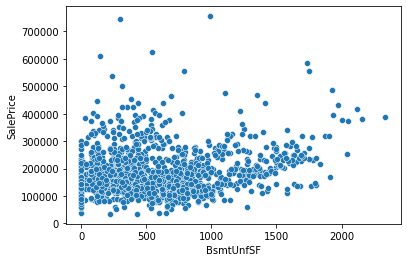

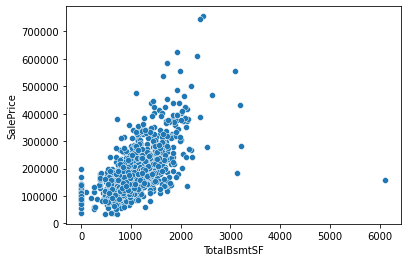

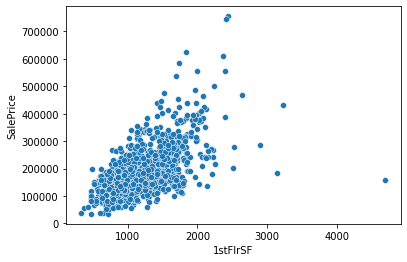

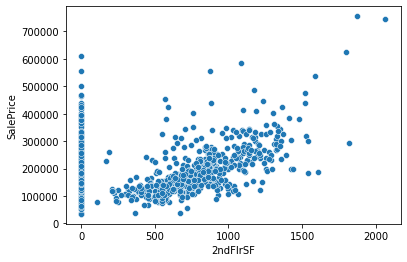

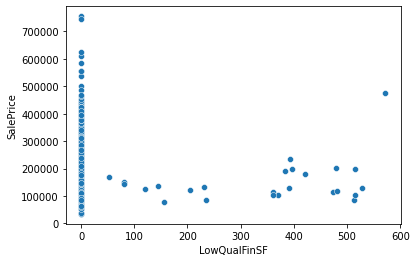

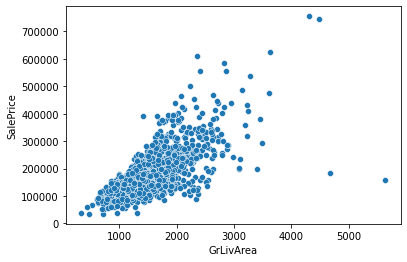

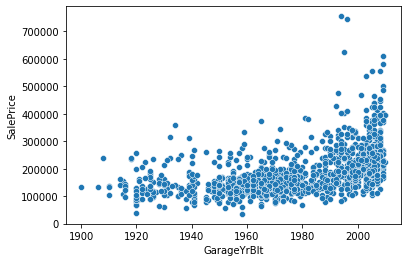

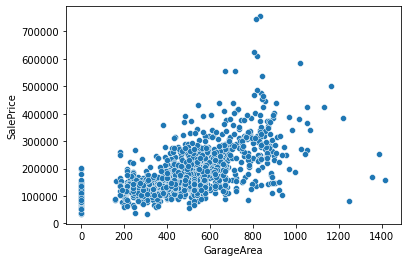

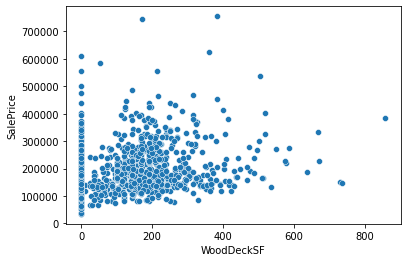

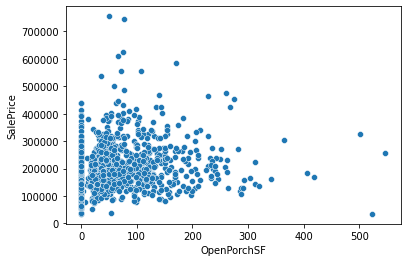

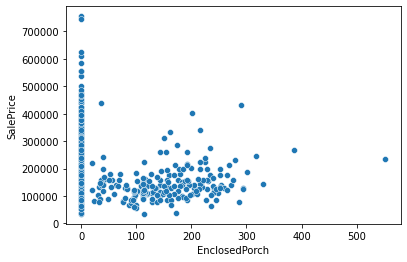

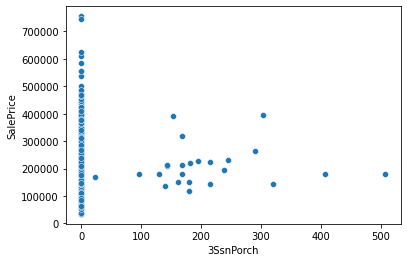

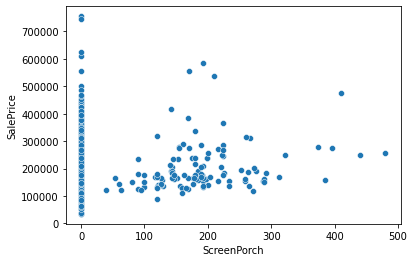

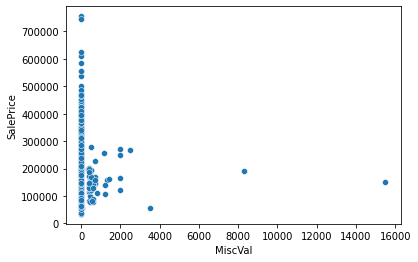

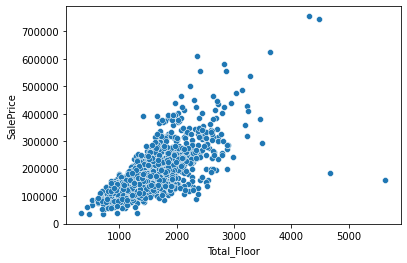

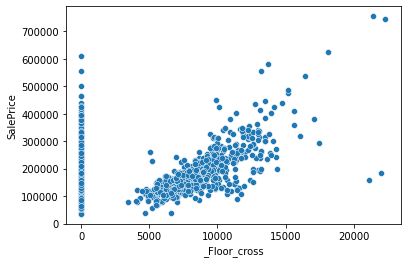

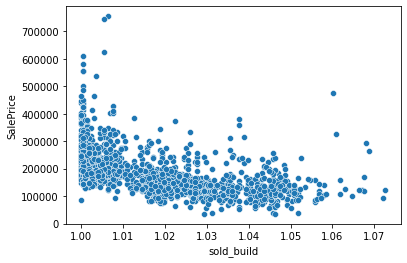

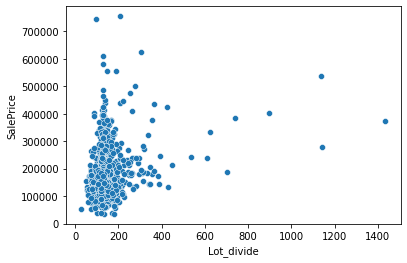

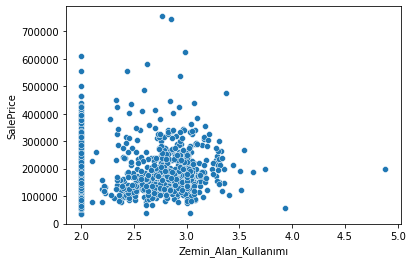

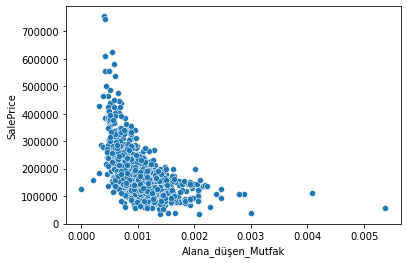

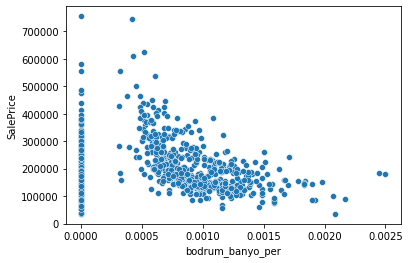

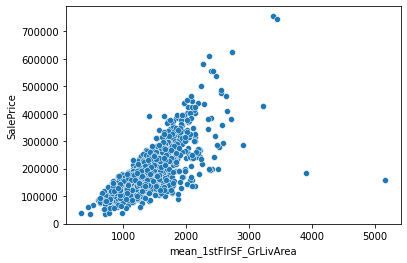

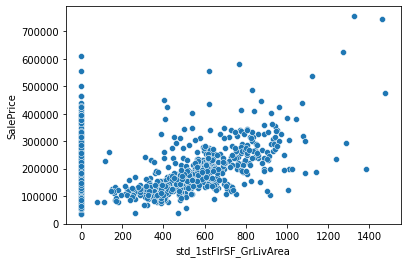

In [157]:
for col in num_cols:
    sns.scatterplot(df[col], df["SalePrice"])
    plt.show()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000,0.000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000
1,1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000,1.000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000
2,2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000,0.000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000
3,3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000,0.000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000
4,4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000,0.000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000


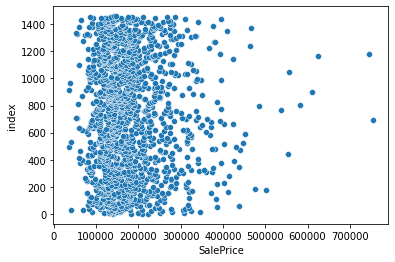

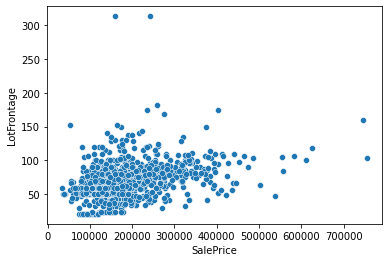

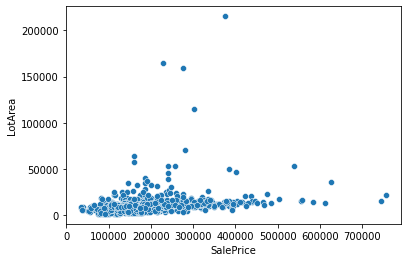

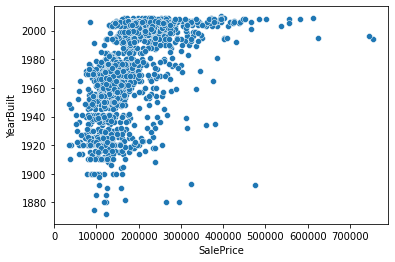

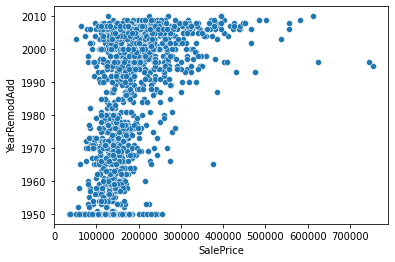

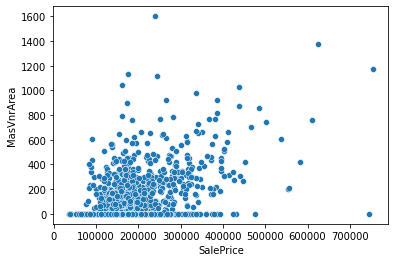

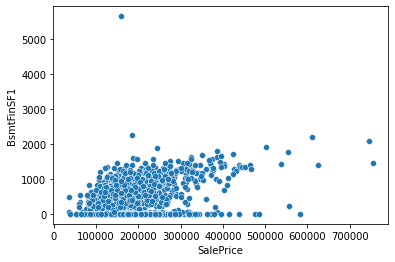

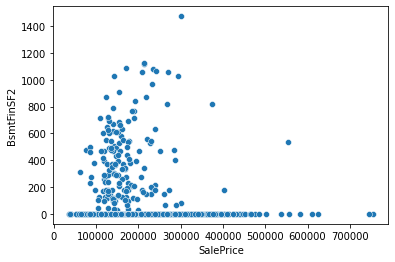

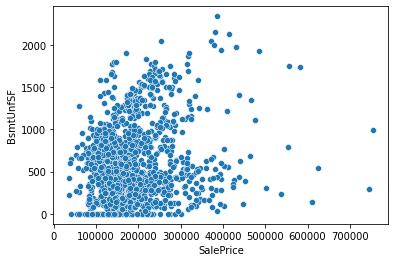

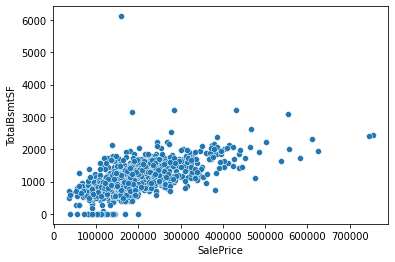

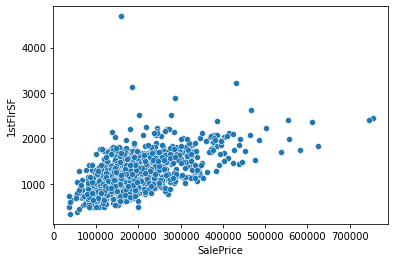

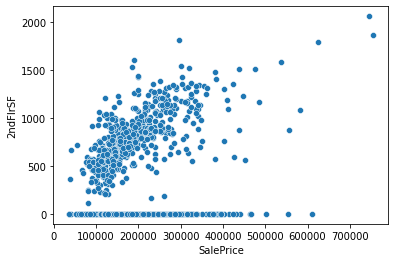

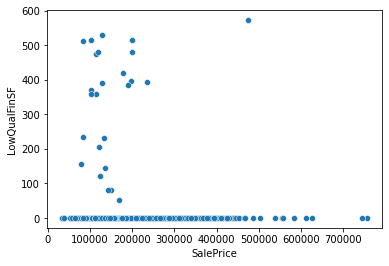

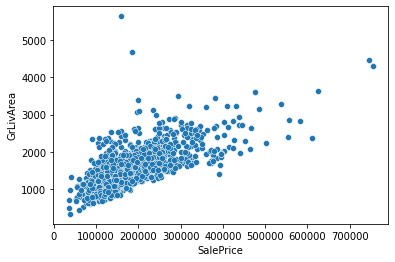

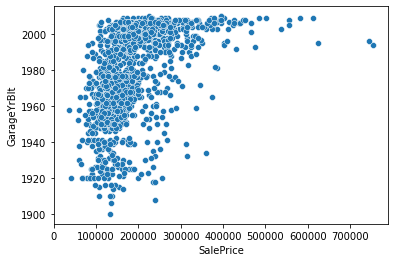

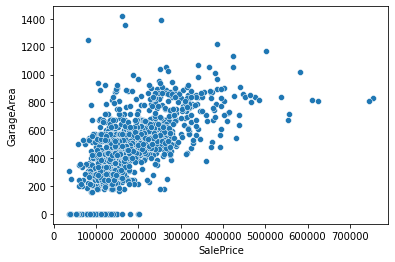

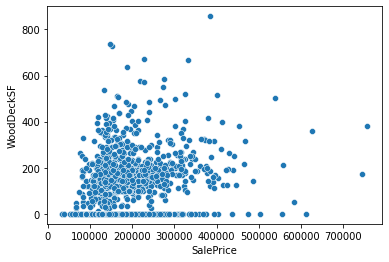

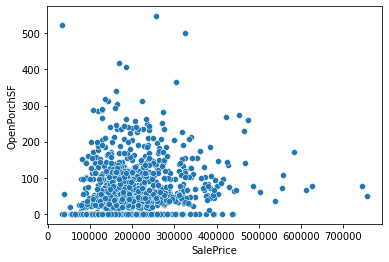

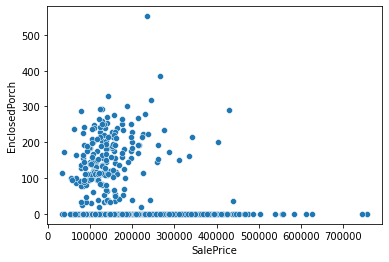

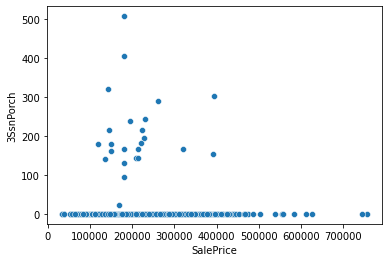

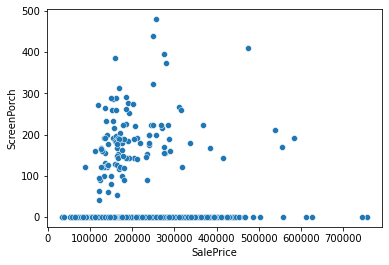

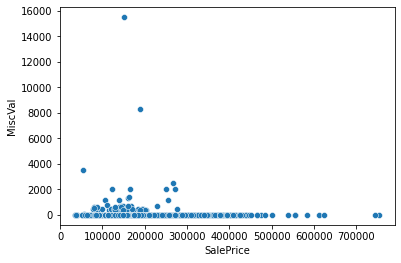

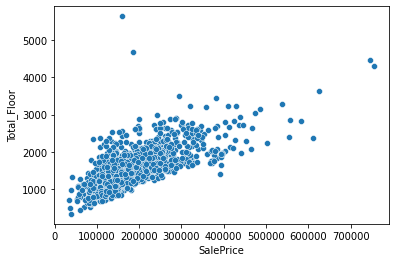

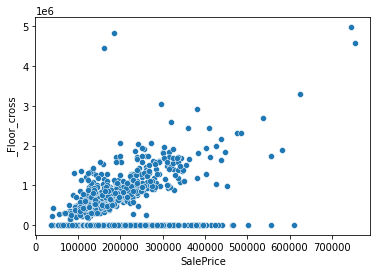

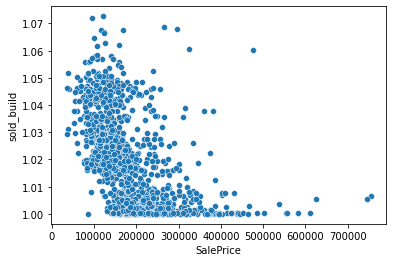

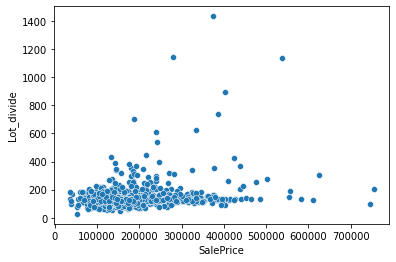

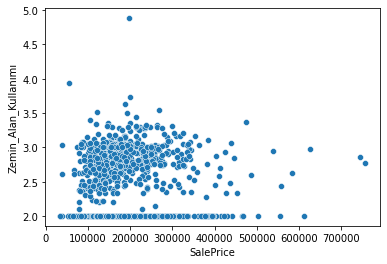

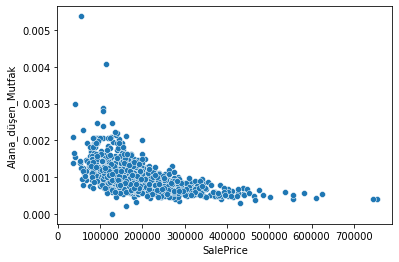

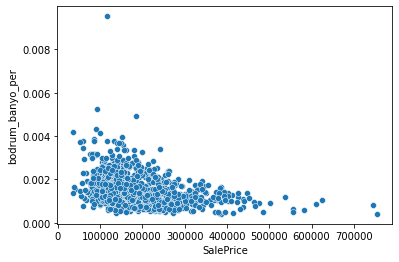

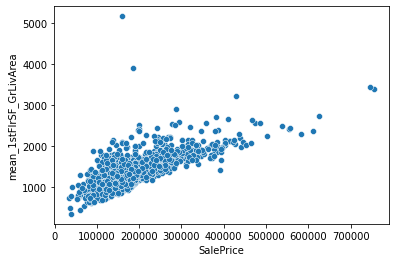

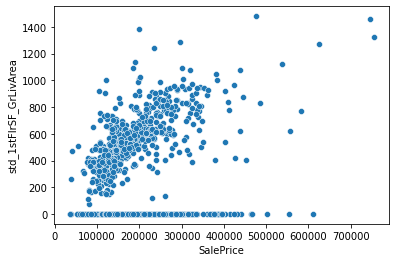

In [145]:
for col in num_cols:
    sns.scatterplot(df["SalePrice"], df[col])
    plt.show()

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
df[num_cols] = scaler.fit_transform(df[num_cols])
print(scaled)

[[0.1225     0.12508859 0.         0.06421233 0.24890162 0.14682985]
 [0.         0.17328136 0.         0.12157534 0.16332378 0.        ]
 [0.10125    0.08610914 0.         0.18578767 0.26341929 0.16002523]
 ...
 [0.         0.04464918 0.         0.12585616 0.13085005 0.0598781 ]
 [0.         0.21686747 0.         0.         0.15606495 0.        ]
 [0.05875    0.13430191 0.         0.10188356 0.30429799 0.20085183]]


In [222]:
na_list = [col for col in df.columns if df[col].isnull().sum() >0 and col not in "SalePrice"]
for col in na_list:
    df.dropna(subset=[col], how = "all", inplace=True)

In [290]:
def one_hot_encoder(df, drop_first=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, drop_first=drop_first)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [274]:
df.head()
    

,Id,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,LowQualFinSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageArea,ScreenPorch,MoSold,SalePrice,Total_Floor,_Floor_cross,MSZoningLotArea_MEAN,MSSubClassWoodDeckSF_MEAN,MSSubClassWoodDeckSF_SUM,MSSubClassWoodDeckSF_MAX,MSSubClassOpenPorchSF_MIN,MSSubClassOpenPorchSF_MEAN,MSSubClassOpenPorchSF_SUM,MSSubClassOpenPorchSF_MAX,MSSubClassTotalBsmtSF_MEAN,MSSubClassTotalBsmtSF_SUM,MSSubClassTotalBsmtSF_MAX,MSSubClassGrLivArea_MIN,MSSubClassGrLivArea_MAX,MSSubClassGrLivArea_SIZE,MSSubClassBuild_MAX,MSSubClass2ndFlrSF_VAR,MSSubClass2ndFlrSF_STD,MSSubClass2ndFlrSF_MEAN,MSSubClass2ndFlrSF_MIN,MSZoning_FV,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_121,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BB,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_OSC,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageCars_2.0,GarageCars_3.0,GarageCars_4.0,GarageCars_5.0,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,1,7,5,196.000,706.000,0.000,150.000,856,0,1.000,2,3,1,8,548.000,0,2,208500.000,1710,731024,11169.472,133.231,76608,870,0,79.897,45941,570,1021.537,587384.000,6110.000,1269,5642,575,76.000,52652.697,229.462,929.445,438,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2,6,8,0.000,978.000,0.000,284.000,1262,0,0.000,2,3,1,6,460.000,0,5,181500.000,1262,0,11169.472,97.281,104966,857,0,46.750,50443,484,1252.864,1350587.000,5095.000,334,5095,1079,61.000,744.037,27.277,0.830,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,

In [292]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [293]:
X =train_df.drop(["SalePrice", "Id"], axis=1)
y = np.log1p(train_df['SalePrice'])

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

In [295]:
models = [("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1433 (XGBoost) 
RMSE: 0.1331 (LightGBM) 
RMSE: 0.1223 (CatBoost) 


In [ ]:


catboost = CatBoostRegressor(verbose=False)

rmse = np.mean(np.sqrt(-cross_val_score(catboost,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

In [ ]:
final_catboost = CatBoostRegressor(verbose=False).fit(X_train, y_train)
y_pred = final_catboost.predict(X_test)

In [ ]:

# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y= np.expm1(y_pred)

In [ ]:
np.sqrt(mean_squared_error(new_y_test, new_y))

In [ ]:
#lgbm_params = {"learning_rate": [0.01,0.02, 0.04, 0.05, 0.1],
               "n_estimators": [500, 1500,2000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000]}
 
#lgbm_gs_best = GridSearchCV(lgbm_model,
                            #lgbm_params,
                           # cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

In [ ]:

#final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

#rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
#rmse